In [1]:
%matplotlib widget
import matplotlib.pyplot as plt

import torch
from pathlib import Path
from datasets import load_from_disk

from galgenai.models import VAE, VAEEncoder, LCFM

from galgenai.training import (
    VAETrainer,
    VAETrainingConfig,
    LCFMTrainer,
    LCFMTrainingConfig,
)

from galgenai.data.hsc import get_dataset_and_loaders

from galgenai import get_device


# Get the best available device
device = get_device()
print(f"Using device: {device}")

# Create output directory structure
output_dir = Path("./pipeline_output")
output_dir.mkdir(exist_ok=True)

Using device: cuda


In [2]:
# ----  DATA LOADING  --------------------------------------------
# =================================================================

print("\n" + "=" * 60)
print("LOADING DATA")
print("=" * 60)

# Path to the HSC mini dataset (HuggingFace format)
data_path = "/data/a/cpac/fkeruzore/hsc_mmu/"

# Load the raw HuggingFace dataset
dataset_raw = load_from_disk(data_path)
print(f"Loaded dataset from: {data_path}")

# Create PyTorch dataset and data loaders
# - nx=64: crop images to 64x64 pixels
# - batch_size=32: small batch for demo
# - Returns (flux, ivar, mask) tuples per batch
dataset, train_loader, val_loader = get_dataset_and_loaders(
    dataset_raw,
    nx=64,  # Crop size (64x64 pixels)
    batch_size=128,  # Batch size for training
    num_workers=8,
    split=0.8,
)
print(f"Dataset size: {len(dataset)} samples")
print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


LOADING DATA
Loaded dataset from: /data/a/cpac/fkeruzore/hsc_mmu/
Images dimension: 5*64*64 (86614 galaxies)
Dataset size: 86614 samples
Train batches: 542, Val batches: 136


In [3]:
# ----  VAE TRAINING (or restoring)  ------------------------------
# =================================================================

restore = True

print("\n" + "=" * 60)
print("TRAINING VAE")
print("=" * 60)

# Create VAE model
# - in_channels=5: HSC has 5 photometric bands (g, r, i, z, y)
# - latent_dim=32: dimension of the latent space
# - input_size=64: matches our crop size
vae = VAE(
    in_channels=5,
    latent_dim=32,
    input_size=64,
)
print(f"VAE parameters: {sum(p.numel() for p in vae.parameters()):,}")

# First pass for fun
vae.eval()
imgs = torch.randn(4, 5, 64, 64)  # .to(device)  # tiny batch
recs, mu, logvar = vae(imgs)

# Configure VAE training
# - num_epochs=5: quick demo training
# - reconstruction_loss_fn="masked_weighted_mse": uses inverse
#   variance weights and masks for bad pixels/noise
# - beta=1.0: standard VAE
vae_config = VAETrainingConfig(
    num_epochs=1,
    learning_rate=2e-3,
    reconstruction_loss_fn="masked_weighted_mse",
    beta=1.0,
    output_dir=str(output_dir / "vae"),
    save_every=8,  # Save checkpoint every 5 epochs
    device=str(device),
)

# Create trainer and run training
encoder_path = output_dir / "encoder.pt"
vae_path = output_dir / "vae.pt"
if restore:
    vae.load_state_dict(torch.load(vae_path, map_location=device, weights_only=False))
    vae.to(device).eval()
else:
    vae_trainer = VAETrainer(
        model=vae,
        train_loader=train_loader,
        config=vae_config,
        val_loader=val_loader,
    )
    vae_trainer.train()

    print("VAE training complete!")
    print(f"Checkpoints saved to: {output_dir / 'vae' / 'checkpoints'}")


    # Extract & save encoder
    print("\n" + "=" * 60)
    print("SAVING FROZEN ENCODER")
    print("=" * 60)


    torch.save(vae.state_dict(), vae_path)
    print(f"VAE saved to: {vae_path}")
    # The VAE has separate encoder and decoder components
    # We save just the encoder for use with LCFM
    torch.save(vae.encoder.state_dict(), encoder_path)
    print(f"Encoder saved to: {encoder_path}")

    # Clean up VAE to free memory before LCFM training
    del vae_trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()



TRAINING VAE
VAE parameters: 30,085,173


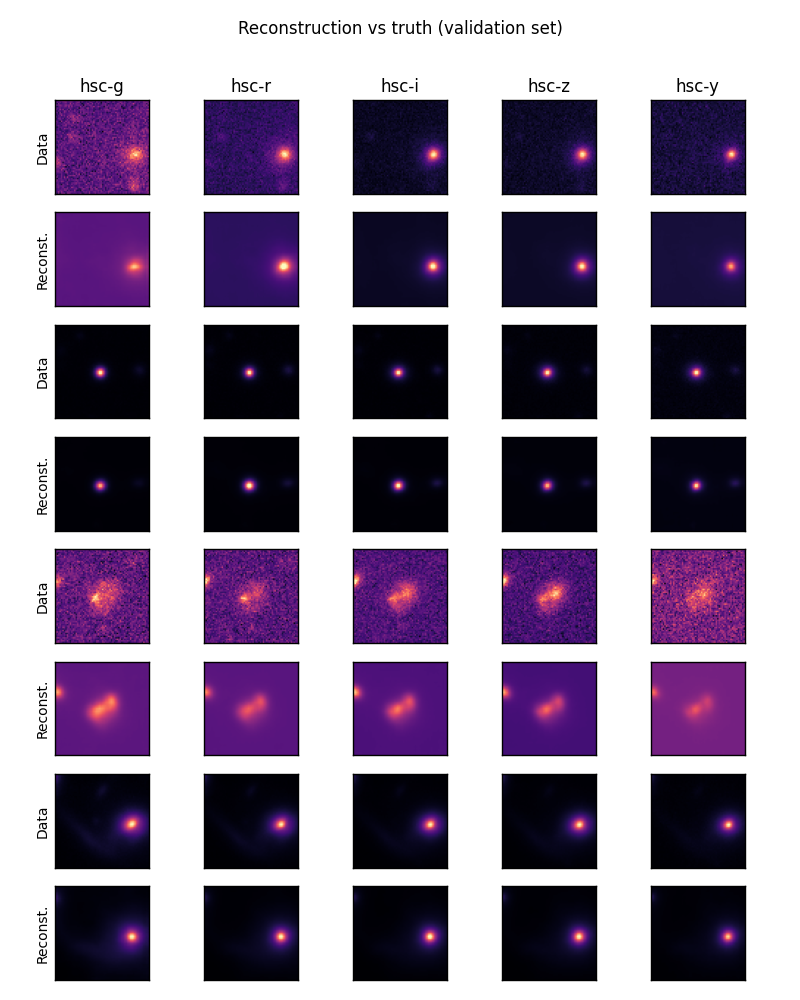

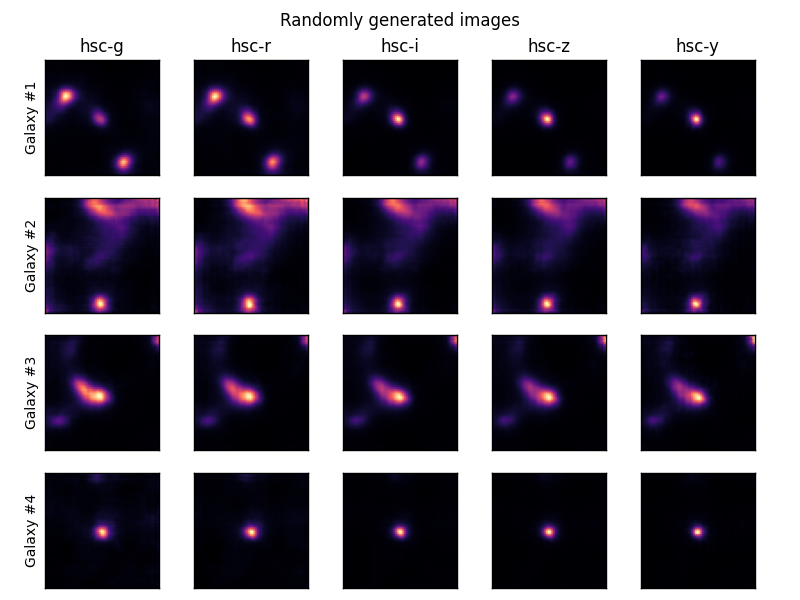

In [4]:
# ----  VAE PLOTS  ------------------------------------------------
# =================================================================

n_bands = len(bands := [f"hsc-{b}" for b in "grizy"])
_n_plot = 4
cmap = plt.get_cmap("magma")
cmap.set_bad("0.5")

vae.eval()
plt.close("all")

# ----  VALIDATION IMAGES RECONSTRUCTION  -------------------------
imgs = torch.stack(next(iter(val_loader)))  # imgs, ivars, masks for a validation batch
imgs = imgs[:, :_n_plot, :, :, :]  # 3, n_plot, n_bands, n_x, n_y
with torch.no_grad():
    recs, _, _ = vae(imgs[0, :, :, :, :].to(device))  # n_plot, n_bands, n_x, n_y

fig, axs = plt.subplots(2*_n_plot, n_bands, figsize=(8, 10))
for i in range(_n_plot):
    img, ivr, msk = imgs[:, i, :, :, :].cpu()
    rec = recs[i].cpu()
    for j, band in enumerate(bands):
        vmin, vmax = img[j].min(), img[j].max()
        axs[2*i+0, j].imshow(img[j] / msk[j], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
        axs[2*i+1, j].imshow(rec[j] / msk[j], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
        if i == 0:
            axs[0, j].set_title(band)
    axs[2*i+0, 0].set_ylabel("Data")
    axs[2*i+1, 0].set_ylabel("Reconst.")


for ax in axs.flatten():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
fig.suptitle("Reconstruction vs truth (validation set)")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.02, top=0.9)


# ----  RANDOM IMAGE GENERATION  ----------------------------------
fig, axs = plt.subplots(_n_plot, n_bands, figsize=(8, 6))
with torch.no_grad():
    imgs = vae.generate(_n_plot, device)
for i in range(_n_plot):
    img = imgs[i].cpu()
    for j, band in enumerate(bands):
        axs[i, j].imshow(img[j], origin="lower", cmap=cmap)
        if i == 0:
            axs[0, j].set_title(band)
    axs[i, 0].set_ylabel(f"Galaxy #{i+1}")

for ax in axs.flatten():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
fig.suptitle("Randomly generated images")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.02, top=0.9)

In [5]:
# ----  LCFM TRAINING  --------------------------------------------
# =================================================================

restore = False

print("\n" + "=" * 60)
print("TRAINING LCFM")
print("=" * 60)

# Create a fresh encoder and load the trained weights
# Must match the VAE encoder architecture
encoder = VAEEncoder(
    in_channels=5,
    latent_dim=32,
    input_size=64,
)
encoder.load_state_dict(torch.load(encoder_path, map_location=device))
encoder.to(device).eval()
print(f"Loaded encoder from: {encoder_path}")


# Create LCFM model
# - Encoder is automatically frozen (requires_grad=False)
# - base_channels=64: U-Net base channel count
# - beta=0.001: KL weight (low for scientific data)
lcfm = LCFM(
    vae_encoder=encoder,
    latent_dim=32,
    in_channels=5,
    base_channels=64,
    beta=0.001,
).to(device)
print(f"LCFM parameters: {sum(p.numel() for p in lcfm.parameters()):,}")
print("  (encoder frozen, only flow network is trained)")

# Configure LCFM training
# - num_steps=500: step-based training (not epochs)
# - learning_rate=2e-4: standard for flow matching
# - warmup_steps=50: linear LR warmup
# - sample_every=250: generate samples periodically
lcfm_config = LCFMTrainingConfig(
    num_steps=2500,
    learning_rate=2e-4,
    warmup_steps=50,
    beta=0.001,
    sample_every=250,
    save_every=500,
    log_every=100,
    output_dir=str(output_dir / "lcfm"),
    device=str(device),
)

lcfm_path = output_dir / "lcfm.pt"
if restore:
    lcfm.load_state_dict(torch.load(lcfm_path, map_location=device, weights_only=False))
    lcfm.to(device).eval()
else:
    # Create trainer and run training
    lcfm_trainer = LCFMTrainer(
        model=lcfm,
        train_loader=train_loader,
        config=lcfm_config,
        val_loader=val_loader,
    )
    lcfm_trainer.train()

    torch.save(lcfm.state_dict(), lcfm_path)
    print(f"VAE saved to: {vae_path}")

    print("LCFM training complete!")
    print(f"Checkpoints saved to: {output_dir / 'lcfm' / 'checkpoints'}")



TRAINING LCFM
Loaded encoder from: pipeline_output/encoder.pt
LCFM parameters: 35,826,365
  (encoder frozen, only flow network is trained)
LCFM Model initialized:
  Trainable parameters: 21,362,821
  Beta (KL weight): 0.001
  Learning rate: 0.0002
  Total training steps: 2,500

Starting training from step 0
Training for 2500 steps
Model compiled with torch.compile()


Training:  10%|█         | 250/2500 [02:07<19:09,  1.96step/s, loss=1.012e+00, flow=3.983e-01, kl=6.138e+02, lr=2.000e-04]

Generating samples at step 250...


Training:  10%|█         | 250/2500 [02:52<19:09,  1.96step/s, loss=1.012e+00, flow=3.983e-01, kl=6.138e+02, lr=2.000e-04]

  Val - Flow: 5.388e-01, KL: 6.650e+02


Training:  20%|██        | 500/2500 [04:57<16:43,  1.99step/s, loss=1.298e+00, flow=3.928e-01, kl=9.056e+02, lr=2.000e-04]  

Generating samples at step 500...


Training:  20%|██        | 500/2500 [05:42<16:43,  1.99step/s, loss=1.298e+00, flow=3.928e-01, kl=9.056e+02, lr=2.000e-04]

  Val - Flow: 3.269e-01, KL: 4.976e+02
Saved checkpoint to pipeline_output/lcfm/checkpoints/step_500.pt


Training:  30%|███       | 750/2500 [07:51<14:37,  1.99step/s, loss=7.218e-01, flow=2.471e-01, kl=4.746e+02, lr=2.000e-04]  

Generating samples at step 750...


Training:  30%|███       | 750/2500 [08:37<14:37,  1.99step/s, loss=7.218e-01, flow=2.471e-01, kl=4.746e+02, lr=2.000e-04]

  Val - Flow: 2.523e-01, KL: 4.291e+02


Training:  40%|████      | 1000/2500 [10:42<12:32,  1.99step/s, loss=5.341e-01, flow=2.254e-01, kl=3.087e+02, lr=2.000e-04] 

Generating samples at step 1000...


Training:  40%|████      | 1000/2500 [11:27<12:32,  1.99step/s, loss=5.341e-01, flow=2.254e-01, kl=3.087e+02, lr=2.000e-04]

  Val - Flow: 2.298e-01, KL: 3.523e+02
Saved checkpoint to pipeline_output/lcfm/checkpoints/step_1000.pt


Training:  50%|█████     | 1250/2500 [13:36<10:26,  2.00step/s, loss=7.618e-01, flow=2.367e-01, kl=5.251e+02, lr=2.000e-04]  

Generating samples at step 1250...


Training:  50%|█████     | 1250/2500 [14:30<10:26,  2.00step/s, loss=7.618e-01, flow=2.367e-01, kl=5.251e+02, lr=2.000e-04]

  Val - Flow: 2.088e-01, KL: 2.859e+02


Training:  60%|██████    | 1500/2500 [16:35<08:21,  1.99step/s, loss=1.995e-01, flow=1.277e-01, kl=7.187e+01, lr=2.000e-04]  

Generating samples at step 1500...


Training:  60%|██████    | 1500/2500 [17:24<08:21,  1.99step/s, loss=1.995e-01, flow=1.277e-01, kl=7.187e+01, lr=2.000e-04]

  Val - Flow: 1.916e-01, KL: 2.447e+02
Saved checkpoint to pipeline_output/lcfm/checkpoints/step_1500.pt


Training:  70%|███████   | 1750/2500 [19:33<06:15,  2.00step/s, loss=2.377e-01, flow=1.387e-01, kl=9.908e+01, lr=2.000e-04]  

Generating samples at step 1750...


Training:  70%|███████   | 1750/2500 [20:28<06:15,  2.00step/s, loss=2.377e-01, flow=1.387e-01, kl=9.908e+01, lr=2.000e-04]

  Val - Flow: 1.887e-01, KL: 2.116e+02


Training:  80%|████████  | 2000/2500 [22:32<04:10,  2.00step/s, loss=4.914e-01, flow=1.811e-01, kl=3.103e+02, lr=2.000e-04]  

Generating samples at step 2000...


Training:  80%|████████  | 2000/2500 [23:18<04:10,  2.00step/s, loss=4.914e-01, flow=1.811e-01, kl=3.103e+02, lr=2.000e-04]

  Val - Flow: 1.879e-01, KL: 1.830e+02
Saved checkpoint to pipeline_output/lcfm/checkpoints/step_2000.pt


Training:  90%|█████████ | 2250/2500 [25:26<02:05,  2.00step/s, loss=1.930e-01, flow=1.326e-01, kl=6.041e+01, lr=2.000e-04]  

Generating samples at step 2250...


Training:  90%|█████████ | 2250/2500 [26:21<02:05,  2.00step/s, loss=1.930e-01, flow=1.326e-01, kl=6.041e+01, lr=2.000e-04]

  Val - Flow: 1.846e-01, KL: 1.614e+02


Training: 100%|██████████| 2500/2500 [28:26<00:00,  2.00step/s, loss=2.081e-01, flow=1.208e-01, kl=8.726e+01, lr=2.000e-04]  

Generating samples at step 2500...


Training: 100%|██████████| 2500/2500 [29:20<00:00,  2.00step/s, loss=2.081e-01, flow=1.208e-01, kl=8.726e+01, lr=2.000e-04]

  Val - Flow: 1.730e-01, KL: 1.449e+02


Training: 100%|██████████| 2500/2500 [29:21<00:00,  1.42step/s, loss=2.081e-01, flow=1.208e-01, kl=8.726e+01, lr=2.000e-04]

Saved checkpoint to pipeline_output/lcfm/checkpoints/step_2500.pt

Training complete!


Saved checkpoint to pipeline_output/lcfm/checkpoints/step_2500.pt
Saved best checkpoint to pipeline_output/lcfm/checkpoints/best.pt
VAE saved to: pipeline_output/vae.pt
LCFM training complete!
Checkpoints saved to: pipeline_output/lcfm/checkpoints


torch.Size([7, 5, 64, 64])
torch.Size([7, 5, 64, 64])


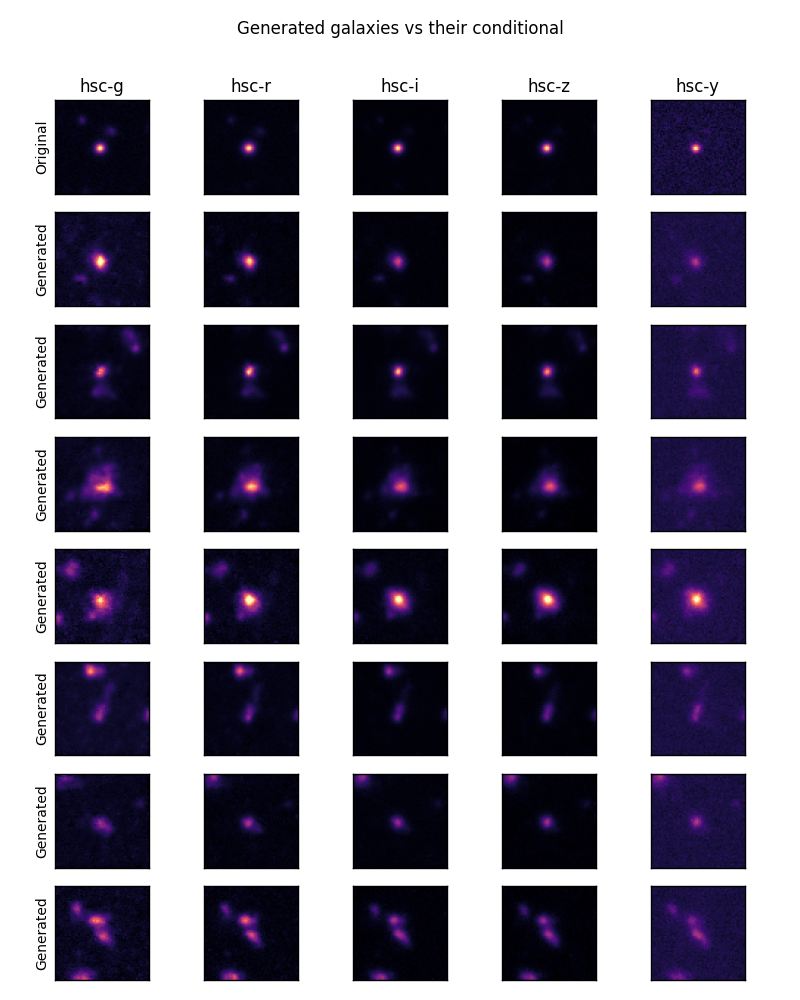

In [21]:
# ----  LCFM PLOTS  -----------------------------------------------
# =================================================================

_n_gen = 7
i_gen = 8
con_img = torch.stack(next(iter(val_loader)))[0, i_gen, :, :, :]
con_imgs = torch.stack([con_img for _ in range(_n_gen)]).to(device)
print(con_imgs.shape)
gen_imgs = lcfm.sample(con_imgs, num_steps=50)
print(gen_imgs.shape)

n_bands = len(bands := [f"hsc-{b}" for b in "grizy"])
cmap = plt.get_cmap("magma")
cmap.set_bad("0.5")

lcfm.eval()

# ----  VALIDATION IMAGES RECONSTRUCTION  -------------------------
fig, axs = plt.subplots(1 + _n_gen, n_bands, figsize=(8, 10))
for i in range(_n_gen + 1):
    img = con_img.cpu() if i == 0 else gen_imgs[i-1].cpu()
    for j, band in enumerate(bands):
        vmin, vmax = con_img[j].cpu().min(), con_img[j].cpu().max()
        axs[i, j].imshow(img[j], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
        if i == 0:
            axs[0, j].set_title(band)
    if i == 0:
        axs[i, 0].set_ylabel("Original")
    else:
        axs[i, 0].set_ylabel("Generated")


for ax in axs.flatten():
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
fig.suptitle("Generated galaxies vs their conditional")
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.02, top=0.9)



In [ ]:
# ----  SUMMARY  --------------------------------------------------
# =================================================================

print("\n" + "=" * 60)
print("TRAINING PIPELINE COMPLETE")
print("=" * 60)
vae_ckpt = output_dir / "vae" / "checkpoints"
lcfm_ckpt = output_dir / "lcfm" / "checkpoints"
best_model = lcfm_ckpt / "best.pt"

print(f"""
Output files:
  - VAE checkpoints:  {vae_ckpt}
  - Frozen encoder:   {encoder_path}
  - LCFM checkpoints: {lcfm_ckpt}
  - LCFM samples:     {output_dir / "lcfm" / "samples"}

To load the trained LCFM model:
    encoder = VAEEncoder(in_channels=5, latent_dim=32,
                         input_size=64)
    encoder.load_state_dict(torch.load("{encoder_path}"))
    lcfm = LCFM(encoder, latent_dim=32, in_channels=5)
    lcfm.load_state_dict(
        torch.load("{best_model}")["model_state_dict"]
    )
""")

